In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy as np
import pandas as pd
import torch
from main import *
from biase_DAGMM import *

#to supress depreciation warnings
import warnings; warnings.simplefilter('ignore')

In [2]:
# LOAD BIASES DATA SET
DATASET = 'biase'  # sys.argv[1]
PREFIX = 'biase'  # sys.argv[2]

filename = DATASET + '.txt'
data = open(filename)
head = data.readline().rstrip().split()

label_file = open(DATASET + '_label.txt')
label_dict = {}

for line in label_file:
    temp = line.rstrip().split()
    label_dict[temp[0]] = temp[1]
label_file.close()

label = []
for c in head:
    if c in label_dict.keys():
        label.append(label_dict[c])
    else:
        print(c)

label_set = []
for c in label:
    if c not in label_set:
        label_set.append(c)
name_map = {value: idx for idx, value in enumerate(label_set)}
id_map = {idx: value for idx, value in enumerate(label_set)}
label = np.asarray([name_map[name] for name in label])

expr = []
for line in data:
    temp = line.rstrip().split()[1:]
    temp = [float(x) for x in temp]
    expr.append(temp)

expr = np.asarray(expr).T

In [3]:
# Log Transform 
expr = np.log2(expr + 1)

# Scale as per the VASC paper 
# for i in range(expr.shape[0]):
#     expr[i, :] = expr[i, :] / np.max(expr[i, :])

In [4]:
lambda_energy = 0.1
lambda_cov_diag = 0.005
num_epochs = 500
lr = 1e-4

In [5]:
model = DaGMM()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
var_expr = to_var(torch.tensor(expr, dtype=torch.float))

In [6]:
latent_dim = []
for i in range(num_epochs):
    enc, dec, z, gamma = model.forward(var_expr)
    total_loss, sample_energy, recon_error, cov_diag = model.loss_function(var_expr, dec, z, gamma, lambda_energy,lambda_cov_diag)
    latent_dim.append(z.data.cpu().numpy())
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    


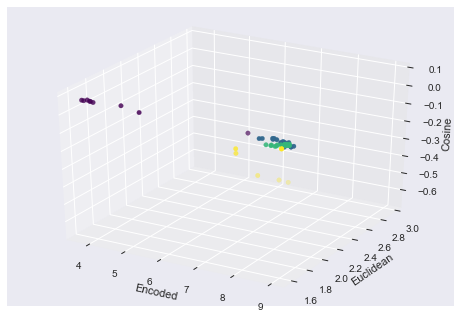

<Figure size 7200x7200 with 0 Axes>

In [26]:
z_last = latent_dim[num_epochs - 1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(z_last[:,1],z_last[:,0], z_last[:,2], c=label, cmap='viridis')
plt.figure(figsize=(100,100))
ax.scatter(z_last[:,0],z_last[:,1], z_last[:,2], c=label, cmap='viridis')
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
# ax.legend()
plt.show()

In [12]:
z_last.shape

(56, 3)